In [1]:
import os
import numpy as np
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, ConvLSTM2D
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
#channels = CONFIG["FEATURES_NAMES"]
#num_channels = len(channels)
#ds_path = CONFIG["COMBINED_PATH"]
#step = int(CONFIG["N_STEPS"])

def preprocess_data(sequence, n_steps,channels):
    #separating nan and non nan points and doing exp space transform
    sequence=np.array(sequence)
    
    undefpts = np.where(sequence!=sequence)
    
    sequence[undefpts]=-1000000
    #print(sequence)
    validpts = np.where(sequence!=-1000000)
    #T = np.max(sequence[validpts])
    #print(channels)
    if channels == "e":
        sequence[validpts]=sequence[validpts]*-1
        #print("dddddddddddddddddddddddddddddddd",sequence[validpts])
    #print(sequence)
    print(np.max(sequence[validpts]))
    sequence[validpts] = sequence[validpts]/np.max(sequence[validpts]) # bringing all valid points down to 0-1
    #converting to new normalized space (i.e. exponential space) 
    sequence[validpts] = np.exp(sequence[validpts])
    sequence[validpts] = np.power(sequence[validpts],7)
    sequence[undefpts] = 0  # assigning 0 to nan
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
ds_path="ddd"
def create_input(channels, ds_path, n_steps):
    stack = []
    for i in range(len(channels)-1):
        input, _ = preprocess_data(xr.open_dataarray('./data/{}.nc'.format(channels[i])), n_steps=n_steps,channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out
channels=["e","tp",'tau','sst','netflux','somxl010']
step=15
input = create_input(channels, ds_path, step)
_, target = preprocess_data(xr.open_dataarray('./data/somxl010250.nc'), n_steps=step,channels=channels[-1])
target = np.expand_dims(target, axis=1)


0.010066949
Adding channel 0 with shape: (465, 15, 1, 81, 69)
0.06534004
Adding channel 1 with shape: (465, 15, 1, 81, 69)
0.25448986887931824
Adding channel 2 with shape: (465, 15, 1, 81, 69)
305.1587
Adding channel 3 with shape: (465, 15, 1, 81, 69)
394.198486328125
Adding channel 4 with shape: (465, 15, 1, 81, 69)
83.55158996582031


In [2]:
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]

n_rows, n_cols = input.shape[-2], input.shape[-1]

print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

x=np.rollaxis(input,4,2)
x=np.rollaxis(x,4,2)
x.shape
y=np.rollaxis(target,3,1)
y=np.rollaxis(y,3,1)
y.shape

INPUT SHAPE -->  (465, 15, 5, 81, 69)
TARGET SHAPE -->  (465, 1, 81, 69)


(465, 81, 69, 1)

In [6]:
loaded_model=tf.keras.models.load_model('./e_tp_tau_sst_netflux_loss.h5')
loaded_model.layers[0].input_shape
prediction=loaded_model.predict(x[380:])
true_value=y[380:]
predicted_value=prediction



In [7]:
true=np.rollaxis(np.array(true_value),2,0)
true=np.rollaxis(true,2,0)
true=np.squeeze(true, axis=3)
true.shape
pred=np.rollaxis(np.array(predicted_value),2,0)
pred=np.rollaxis(pred,2,0)
pred=np.squeeze(pred, axis=3)

pred.shape

(81, 69, 85)

In [8]:
import numpy as np 
np.corrcoef(true_value.flatten(),predicted_value.flatten())

array([[1.        , 0.67265525],
       [0.67265525, 1.        ]])

In [26]:
lon = np.arange(78.5,95.51,0.25)
lat = np.arange(5.5, 25.51, 0.25)
time = pd.date_range("2011-12-15", periods=85,freq='M')
reference_time = pd.Timestamp("2011-11-15")

In [27]:
da = xr.DataArray(
    data=pred,
    dims=["x", "y", "time"],
    coords=dict(
        lon=(["x", "y"], lon),
        lat=(["x", "y"], lat),
        time=time,
        reference_time=reference_time,
    ),
    attrs=dict(
        description="Ambient temperature.",
        units="degC",
    ),
)

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['x', 'y'], array([78.5 , 78.75, 79.  , 79.25, 79.5 , 79.75, 80.  , 80.25, 80.5 ,
       80.75, 81.  , 81.25, 81.5 , 81.75, 82.  , 82.25, 82.5 , 82.75,
       83.  , 83.25, 83.5 , 83.75, 84.  , 84.25, 84.5 , 84.75, 85.  ,
       85.25, 85.5 , 85.75, 86.  , 86.25, 86.5 , 86.75, 87.  , 87.25,
       87.5 , 87.75, 88.  , 88.25, 88.5 , 88.75, 89.  , 89.25, 89.5 ,
       89.75, 90.  , 90.25, 90.5 , 90.75, 91.  , 91.25, 91.5 , 91.75,
       92.  , 92.25, 92.5 , 92.75, 93.  , 93.25, 93.5 , 93.75, 94.  ,
       94.25, 94.5 , 94.75, 95.  , 95.25, 95.5 ])) to Variable.

In [ ]:
arr_lat = np.arange(5.5, 25.51, 0.25)
arr_lon = np.arange(78.5,95.51,0.25)
corr_lat=np.arange(0,80.1,1.0)
corr_lon=np.arange(0,68.1,1.0)
len(corr_lat)
cr=corr

cr['lat'] = cr['lat'].replace(corr_lat,arr_lat)
cr['lon'] = cr['lon'].replace(corr_lon,arr_lon)
cr
c=cr.set_index(['lat','lon'])
ds=c.to_xarray()
ds.to_netcdf('./testing/correlation_files/JJAS.nc')


In [18]:
corr = pd.DataFrame(columns=['lat', 'lon','time', 'correlation'])
len(corr.index)

0

In [23]:
corr.loc[1]=[2,2,3,4]

In [24]:
len(corr.index)

2

In [ ]:
time = pd.date_range("2014-09-06", periods=3)
time

In [45]:
pred2=pred

In [31]:
from tensorflow.keras.layers import *#Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import *#Model



def conv_block(inputs,num_filters):
    x=Conv2D(num_filters,3,padding='same')(inputs)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    x=Conv2D(num_filters,3,padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    return x

def encoder_block(inputs,num_filters):
    x= conv_block(inputs,num_filters)
    p=MaxPool2D((2,2))(x)
    
    return x,p

def decoder_block(inputs,skip_features, num_filters):
    x=Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(inputs)
    x=Concatenate()([x,skip_features])
    x=conv_block(x,num_filters)
    return x

def build_unet(input_shape):
    inputs=Input(input_shape)
    
    s1,p1 =encoder_block(inputs,4)
    s2,p2 =encoder_block(p1,8)
    s3,p3 =encoder_block(p2,16)
    #s4,p4 =encoder_block(p3,32)
    
    #b1=conv_block(p4,64)
    b1=conv_block(p3,32)
    #d1=decoder_block(b1,s4,32)
    d2=decoder_block(b1,s3,16)
    d3=decoder_block(d2,s2,8)
    d4=decoder_block(d3,s1,4)
    
    outputs=Conv2D(1,(1,1),padding="same", activation="relu")(d4)
    
    model=Model(inputs,outputs,name="U-net")
    return model

input_shape=( 80, 64,5)
model=build_unet(input_shape)
model.summary()


Model: "U-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 80, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 80, 64, 4)    184         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 80, 64, 4)    16          conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 80, 64, 4)    0           batch_normalization_24[0][0]     
______________________________________________________________________________________________

In [35]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (80,64,5)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'relu')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
unet()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 80, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_157 (Conv2D)             (None, 80, 64, 64)   2944        input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_158 (Conv2D)             (None, 80, 64, 64)   36928       conv2d_157[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_33 (MaxPooling2D) (None, 40, 32, 64)   0           conv2d_158[0][0]                 
____________________________________________________________________________________________

In [ ]:
 inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsampfele_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [7]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [8]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)

NameError: name 'down_stack' is not defined

In [6]:
import os
import numpy as np
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, ConvLSTM2D
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
#channels = CONFIG["FEATURES_NAMES"]
#num_channels = len(channels)
#ds_path = CONFIG["COMBINED_PATH"]
#step = int(CONFIG["N_STEPS"])

def preprocess_data(sequence, n_steps,channels):
    #separating nan and non nan points and doing exp space transform
    sequence=np.array(sequence)
    
    undefpts = np.where(sequence!=sequence)
    
    sequence[undefpts]=-1000000
    #print(sequence)
    validpts = np.where(sequence!=-1000000)
    #T = np.max(sequence[validpts])
    #print(channels)
    if channels == "e":
        sequence[validpts]=sequence[validpts]*-1
        #print("dddddddddddddddddddddddddddddddd",sequence[validpts])
    #print(sequence)
    print(np.max(sequence[validpts]))
    sequence[validpts] = sequence[validpts]/np.max(sequence[validpts]) # bringing all valid points down to 0-1
    #converting to new normalized space (i.e. exponential space) 
    sequence[validpts] = np.exp(sequence[validpts])
    sequence[validpts] = np.power(sequence[validpts],7)
    sequence[undefpts] = 0  # assigning 0 to nan
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
ds_path="ddd"
def create_input(channels, ds_path, n_steps):
    stack = []
    for i in range(len(channels)-1):
        input, _ = preprocess_data(xr.open_dataarray('./data/{}.nc'.format(channels[i])), n_steps=n_steps,channels=channels[i])
        input = np.expand_dims(input, axis=2)
        print(f"Adding channel {i} with shape: {input.shape}")
        stack.append(input)
    out = np.dstack(stack)
    return out
channels=["e","tp",'tau','sst','netflux','sosaline','somxl010']
step=15
input = create_input(channels, ds_path, step)
_, target = preprocess_data(xr.open_dataarray('./data/somxl010250.nc'), n_steps=step,channels=channels[-1])
target = np.expand_dims(target, axis=1)


0.010066949
Adding channel 0 with shape: (465, 15, 1, 81, 69)
0.06534004
Adding channel 1 with shape: (465, 15, 1, 81, 69)
0.25448986887931824
Adding channel 2 with shape: (465, 15, 1, 81, 69)
305.1587
Adding channel 3 with shape: (465, 15, 1, 81, 69)
159.41363525390625
Adding channel 4 with shape: (465, 15, 1, 81, 69)
35.60245895385742
Adding channel 5 with shape: (465, 15, 1, 81, 69)
83.55158996582031


In [2]:
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]

n_rows, n_cols = input.shape[-2], input.shape[-1]

print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)


INPUT SHAPE -->  (465, 15, 6, 81, 69)
TARGET SHAPE -->  (465, 1, 81, 69)


In [3]:
x=np.rollaxis(input,4,2)
x=np.rollaxis(x,4,2)
x.shape

(465, 15, 81, 69, 6)

In [4]:
y=np.rollaxis(target,3,1)
y=np.rollaxis(y,3,1)
y.shape

(465, 81, 69, 1)

In [5]:
loaded_model=tf.keras.models.load_model('./testing/6channel.h5')
loaded_model.layers[0].input_shape
prediction=loaded_model.predict(x[380:])
true_value=y[380:]
predicted_value=prediction


In [6]:
true=np.rollaxis(np.array(true_value),2,0)
true=np.rollaxis(true,2,0)
true=np.squeeze(true, axis=3)
true.shape
pred=np.rollaxis(np.array(predicted_value),2,0)
pred=np.rollaxis(pred,2,0)
pred=np.squeeze(pred, axis=3)

pred.shape

(81, 69, 85)

In [1]:
np.corrcoef(true_value.flatten(),predicted_value.flatten())[0,1]

NameError: name 'np' is not defined

In [9]:
#globals()[f"corr{i}"] = pd.DataFrame(columns=['lat', 'lon', 'correlation'])
#b[i,j]
#a={'lon':i,'lat':j,'values':values}
#corr.loc[len(corr.index)]=[i,j,correlation]
#corr.join(a)
import pandas as pd
corr = pd.DataFrame(columns=['lat', 'lon', 'correlation'])
b=[]
import math
for i in range(81):
  for j in range(69):
    correlation=np.corrcoef(true[i,j],pred[i,j])[0,1]
    if math.isnan(correlation)==True:
      correlation=0
    #print(values)
    #b[i,j]
    #a={'lon':i,'lat':j,'values':values}
    corr.loc[len(corr.index)]=[i,j,correlation]
    #corr.join(a)
corr

C:\Users\ankit\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\ankit\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,lat,lon,correlation
0,0.0,0.0,0.475008
1,0.0,1.0,0.540626
2,0.0,2.0,0.533912
3,0.0,3.0,0.000000
4,0.0,4.0,0.000000
...,...,...,...
5584,80.0,64.0,0.000000
5585,80.0,65.0,0.000000
5586,80.0,66.0,0.000000
5587,80.0,67.0,0.000000


In [30]:
np.average(x)

0.3090733122927712

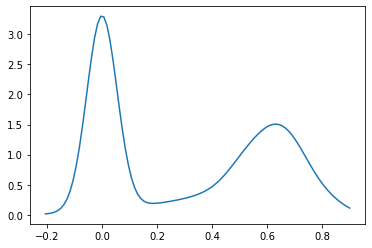

In [40]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace
# create fake data
data = corr['correlation']
# this create the kernel, given an array it will estimate the probability over that values
kde = gaussian_kde( data )
# these are the values over wich your kernel will be evaluated
dist_space = linspace( min(data), max(data), 100 )
# plot the results
plt.plot( dist_space, kde(dist_space) )

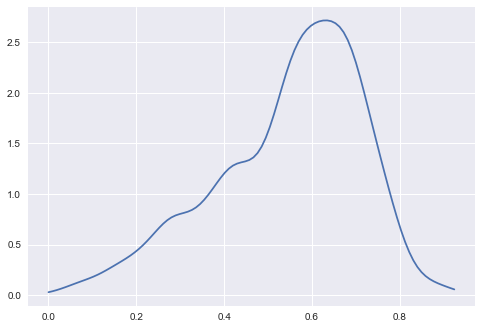

In [18]:
x=corr['correlation']
from scipy.stats.kde import gaussian_kde
import matplotlib.pyplot as plt
from numpy import linspace
# create fake data
plt.style.use('seaborn')
#    ax.set_title('style: {!r}'.format(sty), color='C0')

#    ax.plot(th, np.cos(th), 'C1', label='C1')
#    ax.plot(th, np.sin(th), 'C2', label='C2')
#    ax.legend()
data =[a for a in x if a > 0]
# this create the kernel, given an array it will estimate the probability over that values
kde = gaussian_kde( data )
kde2=gaussian_kde( data*20 )
# these are the values over wich your kernel will be evaluated
dist_space = linspace( min(data), max(data), 100 )
#plt.axes().set_facecolor("light_grey")
# plot the results
plt.plot( dist_space, kde(dist_space) )
#plt.plot( dist_space, kde2(dist_space) )

#ax.set_facecolor("violet")

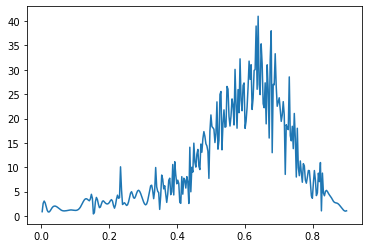

In [43]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

N = len(data)
n = N//10
s = data   # generate your data sample with N elements
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()

In [340]:
arr_lat = np.arange(5.5, 25.51, 0.25)
arr_lon = np.arange(78.5,95.51,0.25)
corr_lat=np.arange(0,80.1,1.0)
corr_lon=np.arange(0,68.1,1.0)
len(corr_lat)
cr=corr

cr['lat'] = cr['lat'].replace(corr_lat,arr_lat)
cr['lon'] = cr['lon'].replace(corr_lon,arr_lon)
cr
c=cr.set_index(['lat','lon'])
ds=c.to_xarray()
ds.to_netcdf('./testing/correlation_files/JJAS.nc')


In [319]:
np.corrcoef(true_value.flatten(),predicted_value.flatten())[0,1]

-0.0023341152530146994

# monthly correlation
ignoring Dec 2011 and so starting with a=1 upto 84, i.e, December 2018

In [17]:
a=predicted_value[2],predicted_value[10]
a=a,predicted_value[18]

In [24]:
np.array(predicted_value).shape

(85, 81, 69, 1)

In [27]:
m=[]

In [115]:
#for i in range(12):
a=11
m11=predicted_value[a],predicted_value[a+12],predicted_value[a+24],predicted_value[a+36],predicted_value[a+48],predicted_value[a+60],predicted_value[a+72]

In [116]:
#for i in range(12):
a=12
t12=true_value[a],true_value[a+12],true_value[a+24],true_value[a+36],true_value[a+48],true_value[a+60],true_value[a+72]

In [117]:
np.array(m11).shape

(7, 81, 69, 1)

In [109]:
pred[5,35]

array([12.11344  , 13.64443  ,  7.9206977,  4.092975 ,  4.7999835,
        8.344371 , 19.729288 , 59.550297 , 36.74391  , 16.268438 ,
       10.38918  ,  4.427229 ,  3.4914522,  8.7681465,  8.408177 ,
        5.531633 ,  3.0667753,  4.352773 ,  5.4422336,  7.1583977,
       21.625603 , 20.225554 ,  7.1200867,  5.9596395,  6.9431467,
        8.181157 ,  7.5332932,  5.623624 ,  5.3468447,  7.056922 ,
        7.16865  ,  9.880225 , 16.15566  , 18.008879 , 12.986385 ,
        5.7163506,  7.4095087, 12.944491 ,  7.900245 ,  3.478803 ,
        3.3241854,  4.081632 ,  8.450784 , 12.075499 , 50.937656 ,
       24.580008 ,  6.3973145,  5.534756 , 11.349813 ,  9.889417 ,
        5.923742 ,  3.7025754,  4.268687 ,  8.633774 , 14.663197 ,
       45.430367 , 46.980515 , 18.314745 ,  8.960624 ,  6.0376077,
        9.042493 , 10.015062 ,  8.7998295,  3.7675722,  3.684892 ,
        6.4236484, 12.751489 , 16.644148 , 27.81873  , 23.973513 ,
        7.6832814,  5.3444057,  9.568608 , 13.236121 , 13.2587

In [87]:
np.corrcoef((np.array(true_value)[1,2],np.pred[1,2])[0,1]

C:\Users\ankit\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\ankit\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


nan

In [121]:
true=np.rollaxis(np.array(t11),2,0)
true=np.rollaxis(true,2,0)
true=np.squeeze(true, axis=3)
true.shape


(81, 69, 7)

In [122]:
pred=np.rollaxis(np.array(m11),2,0)
pred=np.rollaxis(pred,2,0)
pred=np.squeeze(pred, axis=3)

pred.shape

(81, 69, 7)

In [68]:
#mpred=np.squeeze(true,axis=3)
#mtrue=np.squeeze(pred,axis=3)

In [5]:
#globals()[f"corr{i}"] = pd.DataFrame(columns=['lat', 'lon', 'correlation'])
#b[i,j]
#a={'lon':i,'lat':j,'values':values}
#corr.loc[len(corr.index)]=[i,j,correlation]
#corr.join(a)
import pandas as pd
corr = pd.DataFrame(columns=['lat', 'lon', 'correlation'])
b=[]
import math
for i in range(81):
  for j in range(69):
    correlation=np.corrcoef(true[i,j],pred[i,j])[0,1]
    if math.isnan(correlation)==True:
      correlation=0
    #print(values)
    #b[i,j]
    #a={'lon':i,'lat':j,'values':values}
    corr.loc[len(corr.index)]=[i,j,correlation]
    #corr.join(a)
corr

C:\Users\ankit\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\ankit\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,lat,lon,correlation
0,0.0,0.0,0.284823
1,0.0,1.0,0.361459
2,0.0,2.0,0.411400
3,0.0,3.0,0.000000
4,0.0,4.0,0.000000
...,...,...,...
5584,80.0,64.0,0.000000
5585,80.0,65.0,0.000000
5586,80.0,66.0,0.000000
5587,80.0,67.0,0.000000


C:\Users\ankit\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


array([[nan, nan],
       [nan, nan]])

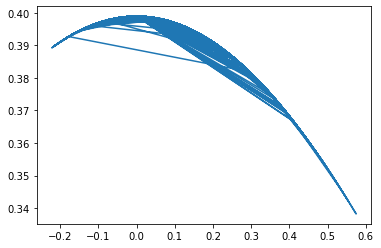

In [230]:
arr_lat = np.arange(5.5, 25.51, 0.25)
arr_lon = np.arange(78.5,95.51,0.25)
corr_lat=np.arange(0,80.1,1.0)
corr_lon=np.arange(0,68.1,1.0)
len(corr_lat)

81

In [231]:
cr=corr

cr['lat'] = cr['lat'].replace(corr_lat,arr_lat)
cr['lon'] = cr['lon'].replace(corr_lon,arr_lon)
cr
c=cr.set_index(['lat','lon'])
ds=c.to_xarray()
ds.to_netcdf('./testing/correlation_files/DJF_2.nc')


# correlation with {}

In [71]:
cr=corr

cr['lat'] = cr['lat'].replace(corr_lat,arr_lat)
cr['lon'] = cr['lon'].replace(corr_lon,arr_lon)
cr
c=cr.set_index(['lat','lon'])
ds=c.to_xarray()
ds.to_netcdf('./h5_files/sosaline_{:2f}.nc'.format(np.corrcoef(true_value.flatten(),predicted_value.flatten())[0,1]))


# Seasonal Corrrelation 

In [156]:
true_value.shape

(85, 81, 69, 1)

In [326]:
#for i in range(12):
a=6
b=7
c=8
t11=true_value[a],true_value[b],true_value[c],
true_value[a+12],true_value[b+12],true_value[c+12],
true_value[a+24],true_value[b+24],true_value[c+24],
true_value[a+36],true_value[b+36],true_value[c+36],
true_value[a+48],true_value[b+48],true_value[c+48],
true_value[a+60],true_value[b+60],true_value[c+60],
true_value[a+72],true_value[b+72],true_value[c+72]

(array([[[13.20105218],
         [11.08414872],
         [ 9.30670913],
         ...,
         [10.1504101 ],
         [ 0.        ],
         [ 0.        ]],
 
        [[12.11620519],
         [10.39578045],
         [ 8.91964518],
         ...,
         [12.04569865],
         [ 0.        ],
         [ 0.        ]],
 
        [[11.12050965],
         [ 9.7501625 ],
         [ 8.54867913],
         ...,
         [14.29487623],
         [ 0.        ],
         [ 0.        ]],
 
        ...,
 
        [[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],
 
        [[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],
 
        [[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]]]),
 array([[[25.789145

In [327]:
a=6
b=7
c=8
m11=predicted_value[a],predicted_value[b],predicted_value[c],
predicted_value[a+12],predicted_value[b+12],predicted_value[c+12],
predicted_value[a+24],predicted_value[b+24],predicted_value[c+24],
predicted_value[a+36],predicted_value[b+36],predicted_value[c+36],
predicted_value[a+48],predicted_value[b+48],predicted_value[c+48],
predicted_value[a+60],predicted_value[b+60],predicted_value[c+60],
predicted_value[a+72],predicted_value[b+72],predicted_value[c+72]

(array([[[ 3.6371958],
         [ 6.2460003],
         [ 6.6001024],
         ...,
         [14.309911 ],
         [12.383111 ],
         [ 9.194777 ]],
 
        [[ 3.5062644],
         [ 7.0242143],
         [ 8.509955 ],
         ...,
         [15.328954 ],
         [14.453006 ],
         [12.054587 ]],
 
        [[ 3.0393035],
         [ 7.058402 ],
         [ 9.145263 ],
         ...,
         [17.028973 ],
         [17.087696 ],
         [15.429323 ]],
 
        ...,
 
        [[ 0.       ],
         [ 0.       ],
         [ 0.       ],
         ...,
         [ 0.       ],
         [ 0.       ],
         [ 0.       ]],
 
        [[ 0.       ],
         [ 0.       ],
         [ 0.       ],
         ...,
         [ 0.       ],
         [ 0.       ],
         [ 0.       ]],
 
        [[ 0.       ],
         [ 0.       ],
         [ 0.       ],
         ...,
         [ 0.       ],
         [ 0.       ],
         [ 0.       ]]], dtype=float32),
 array([[[ 3.786887 ],
         [ 6.3887

In [344]:
true=np.rollaxis(np.array(t11),2,0)
true=np.rollaxis(true,2,0)
true=np.squeeze(true, axis=3)
true.shape
pred=np.rollaxis(np.array(m11),2,0)
pred=np.rollaxis(pred,2,0)
pred=np.squeeze(pred, axis=3)

pred.shape

(81, 69, 4)

In [345]:
np.corrcoef(true.flatten(),pred.flatten())

array([[1.        , 0.56108784],
       [0.56108784, 1.        ]])

# Seasonal correlation

In [341]:
a=11
b=12
c=13
d=14
m11=predicted_value[a],predicted_value[b],predicted_value[c],predicted_value[d]
predicted_value[a+12],predicted_value[b+12],predicted_value[c+12],predicted_value[d+12],
predicted_value[a+24],predicted_value[b+24],predicted_value[c+24],predicted_value[d+24],
predicted_value[a+36],predicted_value[b+36],predicted_value[c+36],predicted_value[d+36],
predicted_value[a+48],predicted_value[b+48],predicted_value[c+48],predicted_value[d+48],
predicted_value[a+60],predicted_value[b+60],predicted_value[c+60],predicted_value[d+60]

(array([[[5.243095 ],
         [7.588801 ],
         [7.164293 ],
         ...,
         [5.069731 ],
         [4.839284 ],
         [4.09052  ]],
 
        [[4.648537 ],
         [7.4844794],
         [8.751933 ],
         ...,
         [5.8782706],
         [6.598799 ],
         [6.5311904]],
 
        [[3.7472394],
         [7.4522753],
         [9.661073 ],
         ...,
         [6.740775 ],
         [7.7269726],
         [7.8588033]],
 
        ...,
 
        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]],
 
        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]],
 
        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]]], dtype=float32),
 array([[[ 4.450656 ],
         [ 6.9009767],
         [ 7.331371 ],
       

In [342]:
#for i in range(12):
a=11
b=12
c=13
d=14
t11=true_value[a],true_value[b],true_value[c],true_value[d]
true_value[a+12],true_value[b+12],true_value[c+12],true_value[d+12],
true_value[a+24],true_value[b+24],true_value[c+24],true_value[d+24],
true_value[a+36],true_value[b+36],true_value[c+36],true_value[d+36],
true_value[a+48],true_value[b+48],true_value[c+48],true_value[d+48],
true_value[a+60],true_value[b+60],true_value[c+60],true_value[d+60]

(array([[[3.98612095],
         [3.98239447],
         [3.97867147],
         ...,
         [2.60618123],
         [2.70747801],
         [2.81271199]],
 
        [[3.79078186],
         [3.72559411],
         [3.66152736],
         ...,
         [2.74524343],
         [2.82942442],
         [2.91618677]],
 
        [[3.60501532],
         [3.48535324],
         [3.36966314],
         ...,
         [2.89172581],
         [2.95686338],
         [3.0234682 ]],
 
        ...,
 
        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]]),
 array([[[4.1244469 ],
         [4.21841707],
         

# Argo correlation

In [15]:
import xarray as xr
a=xr.open_dataarray('./testing/argo/argo_mld_gridded_0.25x.nc')
a

<xarray.DataArray 'mld' (time: 85, latitude: 81, longitude: 69)>
[475065 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2011-12-15 2012-01-15 ... 2018-12-15
  * latitude   (latitude) float64 5.5 5.75 6.0 6.25 ... 24.75 25.0 25.25 25.5
  * longitude  (longitude) float64 78.5 78.75 79.0 79.25 ... 95.0 95.25 95.5
Attributes:
    direction:      IJL
    ioos_category:  Physical Oceanography
    long_name:      argo mixed layer depth
    units:          m

In [30]:
import numpy as np
arg1=np.array(a.fillna(0))
arg1.shape

(85, 81, 69)

In [31]:
arg1[10,19,45]

19.021249294281006

In [32]:
argo=np.rollaxis(arg1,0,2)
argo=np.rollaxis(argo,2,1)

argo.shape

(81, 69, 85)

In [33]:
np.mean(argo)

10.866902866836584

In [40]:
somx=xr.open_dataarray("./data/somxl010250.nc")
somx=somx.fillna(0)
mld=np.array(somx)
mld=np.rollaxis(mld,0,2)
mld=np.rollaxis(mld,2,1)
mld=mld[:,:,395:480]

In [41]:
mld.shape

(81, 69, 85)

# # Checking for hindcast data correlation

In [26]:
import xarray as xr
import numpy as np
t20d_hindcast=xr.open_dataarray('./testing/hindcast/t20d_scratch.nc')
t20d_hindcast=np.array(t20d_hindcast.fillna(0))
t20d_hindcast.shape

(85, 81, 69)

In [27]:
t20d=np.rollaxis(t20d_hindcast,0,2)
t20d=np.rollaxis(t20d,2,1)

t20d.shape

(81, 69, 85)

sequence =t20d

#print("dddddddddddddddddddddddddddddddd",sequence[validpts])
#print(sequence)
undefpts = np.where(sequence!=sequence)
sequence[undefpts]=-1000000
#print(sequence)
validpts = np.where(sequence!=-1000000)
sequence[validpts] = sequence[validpts]/np.max(sequence[validpts]) # bringing all valid points down to 0-1
#converting to new normalized space (i.e. exponential space) 
sequence[validpts] = np.exp(sequence[validpts])
sequence[validpts] = np.power(sequence[validpts],7)
sequence[undefpts] = 0
t20d=sequence
t20d

In [74]:
import pandas as pd
corr = pd.DataFrame(columns=['lat', 'lon', 'correlation'])
b=[]
import math
for i in range(81):
  for j in range(69):
    correlation=np.corrcoef(true[i,j],argo[i,j])[0,1]
    if math.isnan(correlation)==True:
      correlation=0
    #print(values)
    #b[i,j]
    #a={'lon':i,'lat':j,'values':values}
    corr.loc[len(corr.index)]=[i,j,correlation]
    #corr.join(a)
corr

C:\Users\ankit\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\ankit\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,lat,lon,correlation
0,0.0,0.0,0.430006
1,0.0,1.0,0.450739
2,0.0,2.0,0.447831
3,0.0,3.0,0.000000
4,0.0,4.0,0.000000
...,...,...,...
5584,80.0,64.0,0.000000
5585,80.0,65.0,0.000000
5586,80.0,66.0,0.000000
5587,80.0,67.0,0.000000


In [75]:
arr_lat = np.arange(5.5, 25.51, 0.25)
arr_lon = np.arange(78.5,95.51,0.25)
corr_lat=np.arange(0,80.1,1.0)
corr_lon=np.arange(0,68.1,1.0)
len(corr_lat)

81

In [76]:
cr=corr

cr['lat'] = cr['lat'].replace(corr_lat,arr_lat)
cr['lon'] = cr['lon'].replace(corr_lon,arr_lon)
cr
c=cr.set_index(['lat','lon'])
ds=c.to_xarray()['correlation']
ds.to_netcdf('./testing/argo/argo_correlation_with_true_value.nc')
ds

<xarray.DataArray 'correlation' (lat: 81, lon: 69)>
array([[0.43000567, 0.45073945, 0.44783101, ..., 0.        , 0.        ,
        0.        ],
       [0.41932563, 0.44151777, 0.44813385, ..., 0.        , 0.        ,
        0.        ],
       [0.39048759, 0.42071922, 0.43921032, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * lat      (lat) float64 5.5 5.75 6.0 6.25 6.5 ... 24.5 24.75 25.0 25.25 25.5
  * lon      (lon) float64 78.5 78.75 79.0 79.25 79.5 ... 94.75 95.0 95.25 95.5

In [25]:
np.corrcoef(argo.fillna(0).flatten(),true.flatten())

AttributeError: 'numpy.ndarray' object has no attribute 'fillna'

In [37]:
mld.shape

(81, 69, 480)

In [53]:
np.corrcoef(pred.flatten(),mld.flatten())

mean_absolute_percentage_error(pred.flatten(),mld.flatten())


<ipython-input-52-199972fad748>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-52-199972fad748>:3: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


nan

In [52]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
true=np.rollaxis(true_value,2,0)
true=np.rollaxis(true,2,0)
true=np.squeeze(true, axis=3)
true.shape


(81, 69, 85)

In [10]:
pred=np.rollaxis(predicted_value,2,0)
pred=np.rollaxis(pred,2,0)
pred=np.squeeze(pred, axis=3)

pred.shape

(81, 69, 1)

In [11]:
xarr=xr.open_dataarray('./data/somxl010250.nc')


In [12]:
    sequence=np.array(xarr)
    
    undefpts = np.where(sequence!=sequence)
    
    sequence[undefpts]=-1000000
    #print(sequence)
    validpts = np.where(sequence!=-1000000)
    #T = np.max(sequence[validpts])
    #print(channels)
    if channels == "e":
        sequence[validpts]=sequence[validpts]*-1
        #print("dddddddddddddddddddddddddddddddd",sequence[validpts])
    #print(sequence)
    print(np.max(sequence[validpts]))
    max=np.max(sequence[validpts])

83.55158996582031


In [15]:
pred2=np.power(pred,1/7)
pred2=np.log(pred2)
pred2=pred2*max

<ipython-input-15-bce34a56a85a>:2: RuntimeWarning: divide by zero encountered in log
  pred2=np.log(pred2)


In [21]:
import pandas as pd
corr = pd.DataFrame(columns=['lat', 'lon', 'pred_mld'])
b=[]
import math
for i in range(81):
  for j in range(69):
    #correlation=np.corrcoef(true[i,j],pred[i,j])[0,1]
    if math.isinf(pred2[i,j])==True or pred2[i,j]<0:
      pred2[i,j]=0
    #print(values)
    #b[i,j]
    #a={'lon':i,'lat':j,'values':values}
    corr.loc[len(corr.index)]=[i,j,pred2[i,j].item()]
    #corr.join(a)
corr

,lat,lon,pred_mld
0,0.0,0.0,15.933732
1,0.0,1.0,18.897524
2,0.0,2.0,16.197821
3,0.0,3.0,11.248118
4,0.0,4.0,5.210205
...,...,...,...
5584,80.0,64.0,0.000000
5585,80.0,65.0,0.000000
5586,80.0,66.0,0.000000
5587,80.0,67.0,0.000000


In [29]:
corr[]

,lat,lon,correlation
0,5.5,78.50,0.429515
1,5.5,78.75,0.430562
2,5.5,79.00,0.404794
3,5.5,79.25,0.000000
4,5.5,79.50,0.000000
...,...,...,...
5584,25.5,94.50,0.000000
5585,25.5,94.75,0.000000
5586,25.5,95.00,0.000000
5587,25.5,95.25,0.000000


In [22]:
arr_lat = np.arange(5.5, 25.51, 0.25)
arr_lon = np.arange(78.5,95.51,0.25)
corr_lat=np.arange(0,80.1,1.0)
corr_lon=np.arange(0,68.1,1.0)
len(corr_lat)

81

In [23]:
cr=corr

cr['lat'] = cr['lat'].replace(corr_lat,arr_lat)
cr['lon'] = cr['lon'].replace(corr_lon,arr_lon)
cr


,lat,lon,pred_mld
0,5.5,78.50,15.933732
1,5.5,78.75,18.897524
2,5.5,79.00,16.197821
3,5.5,79.25,11.248118
4,5.5,79.50,5.210205
...,...,...,...
5584,25.5,94.50,0.000000
5585,25.5,94.75,0.000000
5586,25.5,95.00,0.000000
5587,25.5,95.25,0.000000


In [24]:
#c=cr.set_index(['lat','lon'])
#ds=c.to_xarray()['pred_mld']
#ds.to_netcdf('./logs/pred_mld_dec_2018.nc')
#ds

<xarray.DataArray 'pred_mld' (lat: 81, lon: 69)>
array([[15.93373203, 18.89752388, 16.19782066, ..., 16.10425758,
        15.92853832, 13.01216316],
       [17.15618896, 19.541399  , 15.67834377, ..., 19.62734985,
        18.81205177, 15.78151321],
       [17.83500481, 20.09392929, 16.09292793, ..., 20.83456039,
        19.89116478, 16.5141964 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
  * lat      (lat) float64 5.5 5.75 6.0 6.25 6.5 ... 24.5 24.75 25.0 25.25 25.5
  * lon      (lon) float64 78.5 78.75 79.0 79.25 79.5 ... 94.75 95.0 95.25 95.5

# monthly correlation

In [248]:
import xarray as xr
ds=xr.open_mfdataset('./datay/*.nc')
df=ds.to_dataframe()
#ds = ds.resample(time="1MS").mean()
#ds["time"]=ds["time"].dt.round("M")
#ds.to_netcdf('./datay/tau.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 69, time: 480)
Coordinates:
  * latitude   (latitude) float64 5.5 5.75 6.0 6.25 ... 24.75 25.0 25.25 25.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
  * longitude  (longitude) float32 78.5 78.75 79.0 79.25 ... 95.0 95.25 95.5
Data variables:
    e          (time, latitude, longitude) float32 dask.array<chunksize=(480, 81, 69), meta=np.ndarray>
    netflux    (time, latitude, longitude) float64 dask.array<chunksize=(480, 81, 69), meta=np.ndarray>
    somxl010   (time, latitude, longitude) float64 dask.array<chunksize=(480, 81, 69), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(480, 81, 69), meta=np.ndarray>
    tau        (time, latitude, longitude) float64 dask.array<chunksize=(480, 81, 69), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(480, 81, 69), meta=np.ndarray>

In [262]:
ds=xr.open_mfdataset('./datay/*.nc')
df=ds.to_dataframe()
df.dropna(subset=['somxl010'],inplace=True)
ds=df.to_xarray()

In [258]:
df.to_xarray()

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 69, time: 480)
Coordinates:
  * latitude   (latitude) float64 5.5 5.75 6.0 6.25 ... 24.75 25.0 25.25 25.5
  * longitude  (longitude) float64 78.5 78.75 79.0 79.25 ... 95.0 95.25 95.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Data variables:
    e          (latitude, longitude, time) float32 -0.004436 ... -0.0016
    netflux    (latitude, longitude, time) float64 73.95 110.8 127.9 ... nan nan
    somxl010   (latitude, longitude, time) float64 18.36 13.76 14.2 ... nan nan
    sst        (latitude, longitude, time) float32 301.1 301.7 302.4 ... nan nan
    tau        (latitude, longitude, time) float64 0.04751 0.0159 ... nan nan
    tp         (latitude, longitude, time) float32 0.001316 ... 0.0001296

In [239]:
#ds["time"]
ds = ds.resample(time="1MS").mean()
#ds["time"]=ds["time"].dt.round("M")
ds.to_netcdf('./datax/tau.nc')
#ds.to_dataframe()

C:\Users\ankit\anaconda3\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


netflux
latitude longitude time                  
5.5      78.5      1979-01-01   73.950455
                   1979-02-01  110.750755
                   1979-03-01  127.908989
                   1979-04-01   87.864372
                   1979-05-01   44.582863
...                                   ...
25.5     95.5      2018-08-01         NaN
                   2018-09-01         NaN
                   2018-10-01         NaN
                   2018-11-01         NaN
                   2018-12-01         NaN

[2682720 rows x 1 columns]

In [ ]:
df.dropna(subset=['ResolutionClass'],inplace=True)

In [150]:
assert input.shape[0] == target.shape[0]
assert input.shape[-1] == target.shape[-1]
assert input.shape[-2] == target.shape[-2]

n_rows, n_cols = input.shape[-2], input.shape[-1]

print("INPUT SHAPE --> ", input.shape)
print("TARGET SHAPE --> ", target.shape)

INPUT SHAPE -->  (465, 15, 5, 81, 69)
TARGET SHAPE -->  (465, 1, 81, 69)


### Model inititalization

In [18]:

seq = keras.Sequential()

seq.add(ConvLSTM2D(filters=4,kernel_size=(3,3),padding='same',input_shape=(15, 81, 69,5),return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=20,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(ConvLSTM2D(filters=8,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=40,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(ConvLSTM2D(filters=8,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=60,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(ConvLSTM2D(filters=16,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
seq.add(ConvLSTM2D(filters=16,kernel_size=(3,3),padding='same',return_sequences=False,data_format='channels_last'))
seq.add(Conv2D(filters=15,kernel_size=(3,3),activation='relu',padding='same',data_format='channels_last'))
seq.add(Conv2D(filters=1,kernel_size=(3,3),activation='relu',padding='same',data_format='channels_last'))
#seq.add(Conv3DTranspose(filters=1,kernel_size=(1,1,1),activation='relu',padding='valid'))

Adam = optimizers.Adam(learning_rate=10**-4)
seq.compile(loss='mean_squared_error',optimizer=Adam,metrics=['mae'])

print(seq.summary())
logdir = "/scratch/ds2/ab4646/mld_1/logs/"

#Train the model...
nepoch=1
tbcallback = callbacks.TensorBoard(log_dir=logdir, histogram_freq=10, batch_size=8, write_graph=True)
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=30, min_lr=0.001)


# In[14]:


#seq.fit(input[:380],target[:380],epochs=nepoch,validation_split=0.1,batch_size=8,callbacks=[tbcallback,reduce_lr,tf.keras.callbacks.TerminateOnNaN()])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 15, 81, 69, 4)     1312      
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 15, 81, 69, 8)     3488      
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 15, 81, 69, 8)     4640      
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 15, 81, 69, 16)    13888     
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 81, 69, 16)        18496     
_________________________________________________________________
conv2d (Conv2D)              (None, 81, 69, 15)        2175      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 81, 69, 1)         1

In [19]:
from keras.utils import plot_model
plot_model(seq, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [20]:
!pip install pydot

In [7]:
!pip install PIL

ERROR: Could not find a version that satisfies the requirement PIL
ERROR: No matching distribution found for PIL


In [63]:
import visualkeras

model = seq
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font).show()  # font is optional!
visualkeras.graph_view(model).show() # display using your system viewer
#visualkeras.layered_view(model, to_file='output.png') # write to disk
#visualkeras.layered_view(model, to_file='output.png').show() # write and show

### converting to nhwc from nhcw

In [116]:
x=np.rollaxis(input,4,2)
x=np.rollaxis(x,4,2)
x.shape

(465, 15, 81, 69, 5)

In [117]:
y=np.rollaxis(target,3,1)
y=np.rollaxis(y,3,1)
y.shape

(465, 81, 69, 1)

### Drop missing from input and target 

In [113]:
x.shape

(465, 15, 81, 69, 5)

In [112]:
#defpts=np.where(x==x)
x[defpts].shape

(194916375,)

In [20]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt
from keras import backend as K
seq = keras.Sequential()

seq.add(ConvLSTM2D(filters=40,kernel_size=(3,3),padding='same',input_shape=(None, 81, 69,5),return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=20,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(BatchNormalization())
seq.add(ConvLSTM2D(filters=40,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=40,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(BatchNormalization())
seq.add(ConvLSTM2D(filters=40,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
#seq.add(TimeDistributed(Conv2DTranspose(filters=60,kernel_size=(3,3),padding='valid',activation='relu')))
seq.add(BatchNormalization())
seq.add(ConvLSTM2D(filters=40,kernel_size=(3,3),padding='same',return_sequences=True,data_format='channels_last'))
seq.add(BatchNormalization())
seq.add(Conv3D(filters=1,kernel_size=(3,3,3),activation= 'sigmoid',padding='same',data_format='channels_last'))
seq.add(BatchNormalization())
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   
                   padding='same', return_sequences=True,data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

print(seq.summary())

# Tensor board for visualization
logdir = "./logs/"
tbcallback = callbacks.TensorBoard(log_dir=logdir, histogram_freq=10, write_graph=True)

#Train the model...
nepoch=2

#seq.fit(x,y, epochs=nepoch,validation_split=0.3)

#seq.save("./logs/5channels.h5")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_10 (ConvLSTM2D) (None, None, 81, 69, 40)  64960     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 81, 69, 40)  160       
_________________________________________________________________
conv_lst_m2d_11 (ConvLSTM2D) (None, None, 81, 69, 40)  115360    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 81, 69, 40)  160       
_________________________________________________________________
conv_lst_m2d_12 (ConvLSTM2D) (None, None, 81, 69, 40)  115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 81, 69, 40)  160       
_________________________________________________________________
conv_lst_m2d_13 (ConvLSTM2D) (None, None, 81, 69, 40) 

In [29]:
print(np.any(np.isnan(input[4,4,0])))
print(np.any(np.isnan(target)))
print(X.shape)
y.shape

False
False
(465, 15, 81, 69, 5)


(465, 81, 69, 1)

In [118]:
loaded_model=tf.keras.models.load_model('5channels_3.h5')
loaded_model.layers[0].input_shape

(None, None, 81, 69, 5)

In [119]:
prediction=loaded_model.predict(x[380:])
true_value=y[380:]
predicted_value=prediction

In [17]:
prediction.shape

(1, 81, 69, 1)

In [29]:
target.shape

(465, 1, 81, 69)

In [12]:
x.shape

(465, 15, 81, 69, 5)

In [22]:
true_value.shape

(85, 81, 69, 1)

In [38]:
np.square(true_value[0].flatten()-predicted_value[0].flatten()).mean()

1941.8965405887604

In [9]:
np.corrcoef(true_value.flatten(),predicted_value.flatten())

array([[1.        , 0.23769133],
       [0.23769133, 1.        ]])

### xr.open_dataset(ds_path)['sst']

In [161]:
#for i in range(56):
#    print(a[i,55,55])
#undefpts=np.where(a!=a)

In [153]:
#a=xr.open_dataset('./rr.nc')

In [150]:
#a=a['netflux'].to_dataframe()

In [160]:
#compression_opts = dict(method='zip',
#                        archive_name='netflux.csv')  
#a["netflux"].to_csv('imd_netflux.zip',
#          compression=compression_opts) 

In [158]:
#a['netflux'].values

In [157]:
#a['n'.isnull().sum()

In [224]:
!conda uninstall tensorflow

^C


In [7]:
#t=np.rollaxis(target,3,1)
#t=np.rollaxis(t,3,1)
true=np.rollaxis(true_value,2,0)
true=np.rollaxis(true,2,0)
true=np.squeeze(true, axis=3)
true.shape

(81, 69, 85)

In [8]:
pred=np.rollaxis(predicted_value,2,0)
pred=np.rollaxis(pred,2,0)
pred=np.squeeze(pred, axis=3)

pred.shape

(81, 69, 85)

In [9]:
true_value.shape

(85, 81, 69, 1)

In [10]:
import pandas as pd
corr = pd.DataFrame(columns=['lat', 'lon', 'correlation'])
b=[]
import math
for i in range(65):
  for j in range(65):
    correlation=np.corrcoef(true[i,j],pred[i,j])[0,1]
    if math.isnan(correlation)==True:
      correlation=0
    #print(values)
    #b[i,j]
    #a={'lon':i,'lat':j,'values':values}
    corr.loc[len(corr.index)]=[i,j,correlation]
    #corr.join(a)
corr

C:\Users\ankit\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\ankit\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,lat,lon,correlation
0,0.0,0.0,0.429515
1,0.0,1.0,0.430562
2,0.0,2.0,0.404794
3,0.0,3.0,0.000000
4,0.0,4.0,0.000000
...,...,...,...
4220,64.0,60.0,0.000000
4221,64.0,61.0,0.000000
4222,64.0,62.0,0.000000
4223,64.0,63.0,0.000000


### arr_lat = np.arange(5.5, 25.51, 0.25)


In [13]:
arr_lon = np.arange(78.5,95.51,0.25)
arr_lat =np.arange(5.5,25.51,0.25)
corr_lat=np.arange(0,80.1,1.0)
corr_lon=np.arange(0,68.1,1.0)
len(corr_lat)

81

In [14]:
cr=corr

cr['lat'] = cr['lat'].replace(corr_lat,arr_lat)
cr['lon'] = cr['lon'].replace(corr_lon,arr_lon)
cr

,lat,lon,correlation
0,5.5,78.50,0.429515
1,5.5,78.75,0.430562
2,5.5,79.00,0.404794
3,5.5,79.25,0.000000
4,5.5,79.50,0.000000
...,...,...,...
4220,21.5,93.50,0.000000
4221,21.5,93.75,0.000000
4222,21.5,94.00,0.000000
4223,21.5,94.25,0.000000


In [15]:
c=cr.set_index(['lat','lon'])
ds=c.to_xarray()['correlation']
ds.to_netcdf('correlation_6channel.nc')
ds

<xarray.DataArray 'correlation' (lat: 65, lon: 65)>
array([[0.42951472, 0.43056221, 0.40479428, ..., 0.40439849, 0.39466292,
        0.37309345],
       [0.19370303, 0.22862302, 0.32393488, ..., 0.41158401, 0.40010046,
        0.38784423],
       [0.10195655, 0.15132644, 0.30045415, ..., 0.4177495 , 0.39226918,
        0.36892919],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * lat      (lat) float64 5.5 5.75 6.0 6.25 6.5 ... 20.5 20.75 21.0 21.25 21.5
  * lon      (lon) float64 78.5 78.75 79.0 79.25 79.5 ... 93.75 94.0 94.25 94.5

In [33]:
ds

<xarray.DataArray 'mld_actual' (lat: 81, lon: 69)>
array([[array([3.1187841]), array([2.85961983]), array([2.62199155]),
        ..., array([2.73081492]), array([0.]), array([0.])],
       [array([3.0985034]), array([2.91240602]), array([2.73748572]),
        ..., array([2.93461453]), array([0.]), array([0.])],
       [array([3.07835458]), array([2.96616659]), array([2.8580672]),
        ..., array([3.15362361]), array([0.]), array([0.])],
       ...,
       [array([0.]), array([0.]), array([0.]), ..., array([0.]),
        array([0.]), array([0.])],
       [array([0.]), array([0.]), array([0.]), ..., array([0.]),
        array([0.]), array([0.])],
       [array([0.]), array([0.]), array([0.]), ..., array([0.]),
        array([0.]), array([0.])]], dtype=object)
Coordinates:
  * lat      (lat) float64 5.5 5.75 6.0 6.25 6.5 ... 24.5 24.75 25.0 25.25 25.5
  * lon      (lon) float64 78.5 78.75 79.0 79.25 79.5 ... 94.75 95.0 95.25 95.5

<AxesSubplot:xlabel='lon', ylabel='lat'>

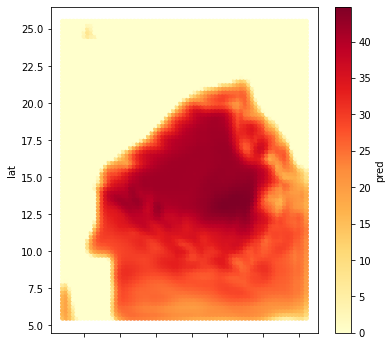

In [69]:
import matplotlib.pyplot as plt
corr.plot(x="lon", y="lat", kind="scatter", c="pred",
        colormap="YlOrRd",use_index=True,figsize=(6,6))
#plt.tight_layout()
#plt.savefig('test.png')

<AxesSubplot:xlabel='lon', ylabel='lat'>

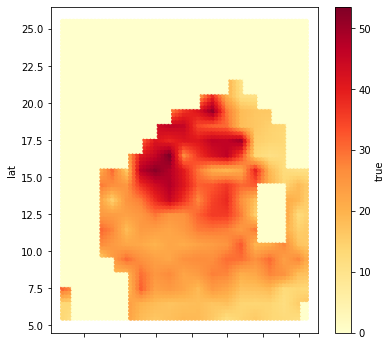

In [76]:
import matplotlib.pyplot as plt
corr.plot(x="lon", y="lat", kind="scatter", c="true",
        colormap="YlOrRd",use_index=True,figsize=(6,6))
#plt.tight_layout()
#plt.savefig('test.png')

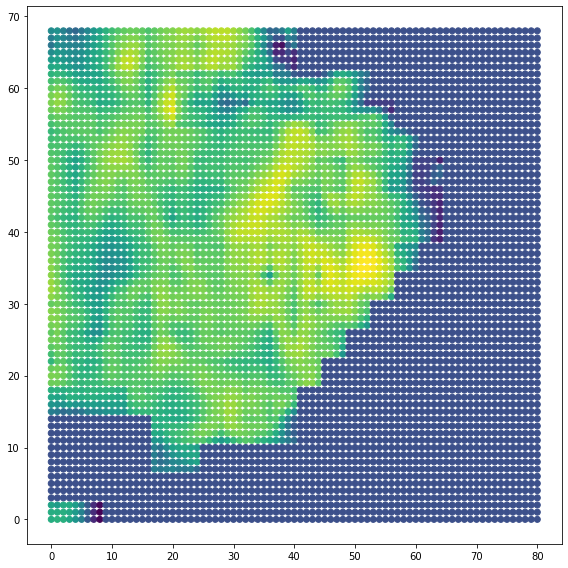

In [26]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
#im = plt.imread("bird_image.png")
fig, ax = plt.subplots()
#im = ax.imshow(im, extent=[0, 300, 0, 300])
#corr.plot(x="lon", y="lat", , c="values",
#        colormap="YlOrRd",use_index=True,figsize=(8,8))
#x = np.array(range(300))
ax.scatter(corr['lat'], corr['lon'], c=corr['values'])
plt.show()

In [149]:
corr.to_xarray()

<xarray.Dataset>
Dimensions:  (index: 5589)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 5582 5583 5584 5585 5586 5587 5588
Data variables:
    lat      (index) float64 0.0 0.0 0.0 0.0 0.0 ... 80.0 80.0 80.0 80.0 80.0
    lon      (index) float64 0.0 1.0 2.0 3.0 4.0 ... 64.0 65.0 66.0 67.0 68.0
    values   (index) float64 0.4489 0.4488 0.4046 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [ ]:
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r

In [49]:
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 64)
visualkeras.layered_view(seq,legend=True,scale_xy=22, scale_z=1, max_z=1000,font=font).show()

In [96]:
#from neuralplot import neuralplot
neuralplot(seq,grid=False,connection=True,linewidth=0.1)

TypeError: 'module' object is not callable

In [ ]:
np.corr

In [154]:
import pandas as pd
names = ['x', 'y', 'z']
index = pd.MultiIndex.from_product([range(s)for s in t2.shape], names=names)
df = pd.DataFrame({'values': t2.flatten()}, index=index)['values']
df=df.reset_index()
df

,x,y,z,values
0,0,0,0,3.217379
1,0,0,1,5.421850
2,0,0,2,11.287831
3,0,0,3,6.568510
4,0,0,4,5.311463
...,...,...,...,...
2598880,80,68,460,0.000000
2598881,80,68,461,0.000000
2598882,80,68,462,0.000000
2598883,80,68,463,0.000000


In [48]:
!pip install cartopy

^C


In [56]:
ee=xr.open_dataset('correlation.nc')
ee

<xarray.Dataset>
Dimensions:      (lat: 81, lon: 69)
Coordinates:
  * lat          (lat) float64 0.0 1.0 2.0 3.0 4.0 ... 76.0 77.0 78.0 79.0 80.0
  * lon          (lon) float64 78.5 78.75 79.0 79.25 ... 94.75 95.0 95.25 95.5
Data variables:
    correlation  (lat, lon) float64 ...

In [38]:
a=(xr.open_dataarray('./data2/so_oras.nc'))
a

<xarray.DataArray 'so_oras' (time: 9496, latitude: 81, longitude: 69)>
[53073144 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 5.5 5.75 6.0 6.25 ... 24.75 25.0 25.25 25.5
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-12-31
  * longitude  (longitude) float32 78.5 78.75 79.0 79.25 ... 95.0 95.25 95.5
Attributes:
    long_name:      Salinity
    standard_name:  sea_water_salinity
    units:          1e-3
    unit_long:      Practical Salinity Unit
    cell_methods:   area: mean
    _ChunkSizes:    [  1  15 137 288]

In [28]:
b=np.array(a)

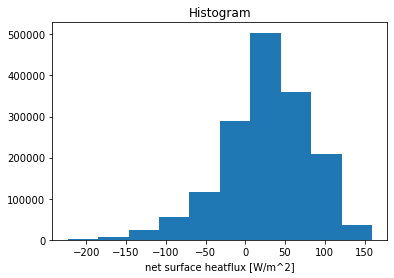

In [34]:
a.plot.hist()
pyplot.show()

ValueError: x must have 2 or fewer dimensions

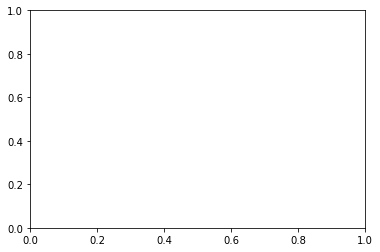

In [29]:
from matplotlib import pyplot
# seed the random number generator

# generate univariate observati# histogram plot
pyplot.hist(b)
pyplot.show()